In [1]:
from pathlib import Path
from definitions import ROOT_DIR
import pandas as pd
import numpy as np
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})

In [15]:
def calculate_detected_intensities(df, threshold=0.8):
    '''
    Make a column with background corrected intensities for detected compounds, and 0s for not detected compounds
    Change any negative values to zero
    Also add detectability column, where compounds with prediction value above threshold=0.8 are labelled as detected (1)
    '''

    df['detectability'] = df.pred_val >= threshold
    vals = df.spot_intensity_bgr_corrected * df.detectability
    df['effective_intensity'] = np.clip(vals, 0, None)
    return df

def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata

def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df

def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df

def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df

def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    
    return data

def group_by_molecule(df):
    '''
    Aggregate intensity and detection values per metabolite and dataset
    '''
    
    data = df.pivot_table(index=['name_short', 'Matrix short'],
                 values=['effective_intensity', 'detectability'],
                 aggfunc=
                        {'effective_intensity':'sum',
                        'detectability':'max'}).reset_index()
    return data

def summarise_per_class(df, class_col_name):
    
    data = df.pivot_table(index=['Matrix short', class_col_name],
                      values=['effective_intensity', 'detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'effective_intensity':'mean',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    data['log10_intensity'] = data.effective_intensity.apply(lambda x: np.log10(x+1))
    
    return data

def zero_fill_data(df, classification, class_col_name):
    
    # Do zero-filling using a pre-made template
    X = df['Matrix short'].unique()
    Y = classification[class_col_name].unique()
    template = pd.DataFrame(product(X, Y), columns=['Matrix short', class_col_name])
    data = template.merge(df, on=['Matrix short', class_col_name], how='left').fillna(0)
    
    return data

def plot_dot_plot(data, cmap, class_col_name, intensity_col_name, title="", figsize=(12,4.5)):
    
    plt.figure(figsize=figsize)
    g = sns.scatterplot(data=data, 
                        x='Matrix short', 
                        y=class_col_name, 
                        size="fraction_detected", 
                        sizes=(0, 400), #smallest and largest bubble size to use
                        size_norm=(0, 1), #fraction range
                        hue=intensity_col_name, 
                        hue_norm=(1, 5.5), #intensity range
                        palette=cmap,
                        linewidth = 0,
                        edgecolor='k',
                        legend='brief'
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation=90)
    plt.tight_layout()

    return g

# size_norm and hue_norm make sure the same dot size and colour limits apply to all plots, 
# but it is not evident from the way legend is shown. If you want to double check, set legend='full' in plot function call

- Inputs

In [3]:
p_root_dir = Path(ROOT_DIR).parents[0]
p_data = p_root_dir / "5_data_analysis"
p_out = p_root_dir / "6_plots/q2_plots/dot_plots"

# Metrics and Catboost predictions for all ions in their target wells
p_predictions = p_data / "all_predictions_curated_11-Dec-2021.csv"

# Dataset info (lab, matrix, polarity, m/z range, ids, etc.)
p_datasets = p_data / "Datasets_14Jul2022.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"
p_pathways = p_data / "pathways_v2.csv"

- Merge relevant info into one dataframe

In [4]:
# Load predictions, format neutral loss column
predictions = pd.read_csv(p_predictions, index_col=0)[['dataset_id', 
                                                       'name_short', 
                                                       'adduct', 
                                                       'neutral_loss', 
                                                       'pred_val',
                                                       'spot_intensity_bgr_corrected']]
predictions.neutral_loss.fillna('', inplace=True)

# Add dataset metadata 
datasets = pd.read_csv(p_datasets)
datasets_info = datasets.groupby('Dataset ID').first()[['Polarity', 'Matrix short', 'Matrix long', 'Slide code', 'EMBL']]

# Merge with predictions
df = pd.merge(predictions, datasets_info, left_on='dataset_id', right_on='Dataset ID', how='left')

# Filter to keep only datasets chosen for plots about matrix comparison
df = df[df.EMBL]

# only consider data of detected ions
df = calculate_detected_intensities(df, threshold=0.8)
data = df[df.detectability]

In [5]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')
chem_subclass = get_class_size(classes[['name_short', 'coarse_class', 'fine_class']],  # coarse class here is to sort rows in the plot
                              'fine_class')

functions = pd.read_csv(p_pathways, index_col='internal_id')
pathways = get_class_size(functions[['name_short', 'main_coarse_path']].drop_duplicates(),
                         'main_coarse_path')
pathway_subclass = get_class_size(functions[['name_short', 'coarse_path', 'fine_path']],
                                  'fine_path')

In [6]:
# Choose colourmap
cmap = sns.choose_colorbrewer_palette('s', as_cmap=True)

interactive(children=(Dropdown(description='name', options=('Greys', 'Reds', 'Greens', 'Blues', 'Oranges', 'Pu…

### Part 1: Dot plot with main chemical classes or pathways

In [16]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='negative', 
#                            adducts=None,
                            neutral_losses=[''])

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data)

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, class_col_name='main_coarse_class')

# Zero-fill
plot_data = zero_fill_data(class_data, 
                           classification=chem_class, 
                           class_col_name='main_coarse_class')

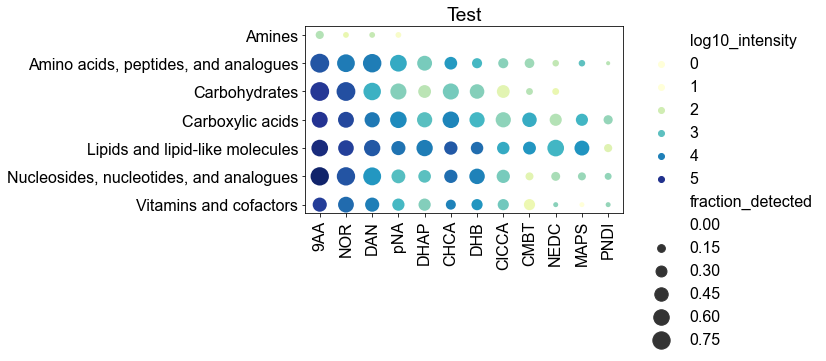

In [9]:
# Set the order for axes

# OX_order = ['DHB', 'ClCCA', 'CHCA', 'pNA', 'DHAP', 'CMBT', 'DAN', 'NOR', '9AA', 'NEDC', 'MAPS', 'PNDI'] #pos
OX_order = ['9AA', 'NOR', 'DAN', 'pNA', 'DHAP', 'CHCA', 'DHB', 'ClCCA', 'CMBT', 'NEDC', 'MAPS', 'PNDI'] #neg
plot_data['Matrix short'] = pd.Categorical(plot_data['Matrix short'], OX_order) #X-axis
plot_data.sort_values(by='main_coarse_class', inplace=True) #Y-axis

# Make the pot
plot = plot_dot_plot(plot_data,
                            cmap, 
                            class_col_name='main_coarse_class', 
                            intensity_col_name = 'log10_intensity',
                            title = 'Test',
                            figsize=(12, 4.5))

# plot.figure.savefig(p_out / f"test.pdf")

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With chemical classes or biochemical pathways

In [10]:
for neutral_losses in [None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative']:
        
        # Specify desired OX order for a chosen polarity
        if polarity == 'positive':
            OX_order = ['DHB', 'ClCCA', 'CHCA', 'pNA', 'DHAP', 'CMBT', 'DAN', 'NOR', '9AA', 'NEDC', 'MAPS', 'PNDI'] #pos
        else: OX_order = ['9AA', 'NOR', 'DAN', 'pNA', 'DHAP', 'CHCA', 'DHB', 'ClCCA', 'CMBT', 'NEDC', 'MAPS', 'PNDI'] #neg

    
        filtered_data = filter_data(data,
                                    polarity=polarity, 
                                    neutral_losses=neutral_losses)
        
        # Summarise data per metabolite and dataset (intensities of detected ions are summed)
        molecule_data = group_by_molecule(filtered_data)
        
        for classification, class_col_name in zip([chem_class, pathways], ['main_coarse_class', 'main_coarse_path']):

            # Map chemical class to the metabolite
            mapped_data = molecule_data.merge(classification, on='name_short', how='left')

            # Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
            class_data = summarise_per_class(mapped_data, class_col_name)
            class_data['log10_intensity'] = class_data.effective_intensity.apply(lambda x: np.log10(x+1))
        
            # Zero-fill data
            plot_data = zero_fill_data(class_data, 
                                       classification, 
                                       class_col_name)
            
            # Set the order for axes
            plot_data['Matrix short'] = pd.Categorical(plot_data['Matrix short'], OX_order) # X-axis
            plot_data.sort_values(by=class_col_name, inplace=True) # Y-axis
            
            # Make the plot
            title = f"Fraction and avg.intensity {polarity} {nl_label} {class_col_name}"
            g = plot_dot_plot(plot_data, 
                                     cmap, 
                                     class_col_name=class_col_name, 
                                     intensity_col_name = f'log10_intensity',
                                     title=title,
                                     figsize=(12,4.5))
                
            # Save the plot
            g.figure.savefig(p_out / f"{title}.png")
            g.figure.savefig(p_out / f"{title}.pdf")
            plt.close()  

# Part 2: Dot plot with fine chemical classes or pathways

In [11]:
# Choose polarity, filter adducts and neutral losses
filtered_data = filter_data(data,
                            polarity='positive', 
#                            adducts=None,
                            neutral_losses=[''])

# Summarise data per metabolite and dataset (intensities of detected ions are summed)
molecule_data = group_by_molecule(filtered_data)

# Map chemical class to the metabolite
mapped_data = molecule_data.merge(chem_subclass, on='name_short', how='left')

# Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
class_data = summarise_per_class(mapped_data, class_col_name='fine_class')
class_data['log10_intensity'] = class_data.effective_intensity.apply(lambda x: np.log10(x+1))

# Zero-fill_data
plot_data = zero_fill_data(class_data, chem_subclass, 'fine_class')

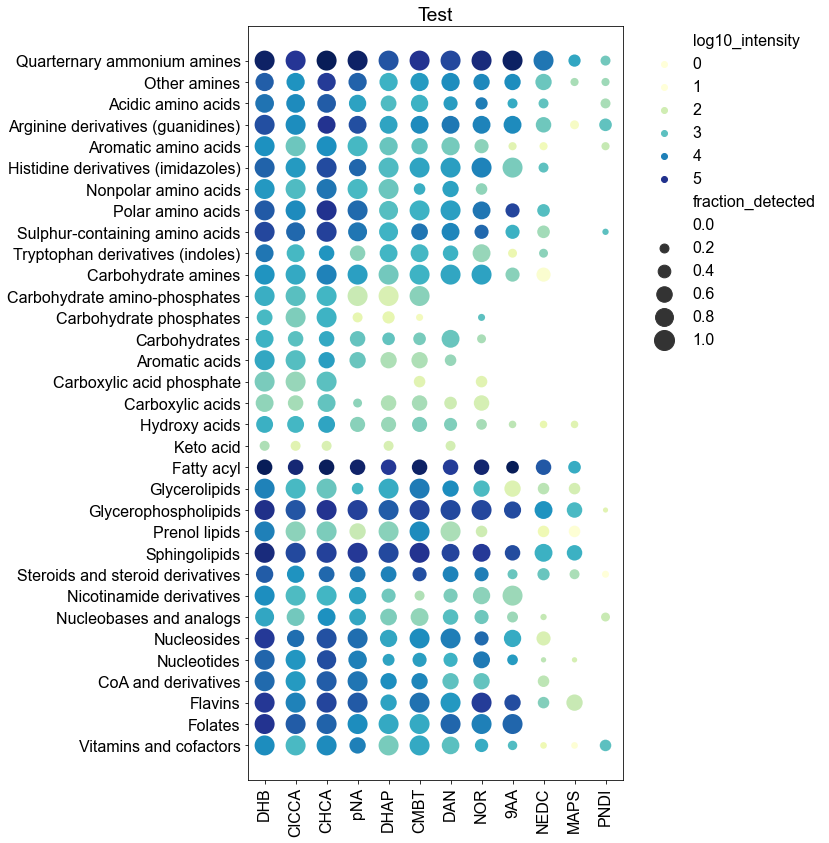

In [12]:
# Set the order for axes
OX_order = ['DHB', 'ClCCA', 'CHCA', 'pNA', 'DHAP', 'CMBT', 'DAN', 'NOR', '9AA', 'NEDC', 'MAPS', 'PNDI'] #pos
# OX_order = ['9AA', 'NOR', 'DAN', 'pNA', 'DHAP', 'CHCA', 'DHB', 'ClCCA', 'CMBT', 'NEDC', 'MAPS', 'PNDI'] #neg

# OY_order = chem_subclass.sort_values(by=['coarse_class', 'fine_class']).fine_class.unique()
OY_order = ['Quarternary ammonium amines', 'Other amines',
       'Acidic amino acids', 'Arginine derivatives (guanidines)',
       'Aromatic amino acids', 'Histidine derivatives (imidazoles)',
       'Nonpolar amino acids', 'Polar amino acids',
       'Sulphur-containing amino acids',
       'Tryptophan derivatives (indoles)', 'Carbohydrate amines',
       'Carbohydrate amino-phosphates', 'Carbohydrate phosphates',
       'Carbohydrates', 'Aromatic acids', 'Carboxylic acid phosphate',
       'Carboxylic acids', 'Hydroxy acids', 'Keto acid', 'Fatty acyl',
       'Glycerolipids', 'Glycerophospholipids', 'Prenol lipids',
       'Sphingolipids', 'Steroids and steroid derivatives',
       'Nicotinamide derivatives', 'Nucleobases and analogs',
       'Nucleosides', 'Nucleotides', 'CoA and derivatives', 'Flavins',
       'Folates', 'Vitamins and cofactors']


plot_data['Matrix short'] = pd.Categorical(plot_data['Matrix short'], OX_order)
plot_data['fine_class'] = pd.Categorical(plot_data['fine_class'], OY_order)


plot = plot_dot_plot(plot_data,
                    cmap, 
                    class_col_name='fine_class', 
                    intensity_col_name = 'log10_intensity',
                    title = 'Test',
                    figsize=(12,12))

# plot.figure.savefig(p_out / f"test.pdf")

- Batch-save many plots with changing filters:

1. With and without neutral losses
2. In both ionisation modes
3. With chemical classes or biochemical pathways

In [13]:
for neutral_losses in [None, [''], 'only_nl']:
    
    nl_label = 'with n.l.'
    if neutral_losses == ['']: 
        nl_label = 'no n.l.'  
    elif neutral_losses == 'only_nl':
        nl_label = 'only n.l.'  

    for polarity in ['positive', 'negative']:
        
        # Specify desired OX order for a chosen polarity
        if polarity == 'positive':
            OX_order = ['DHB', 'ClCCA', 'CHCA', 'pNA', 'DHAP', 'CMBT', 'DAN', 'NOR', '9AA', 'NEDC', 'MAPS', 'PNDI'] #pos
        else: OX_order = ['9AA', 'NOR', 'DAN', 'pNA', 'DHAP', 'CHCA', 'DHB', 'ClCCA', 'CMBT', 'NEDC', 'MAPS', 'PNDI'] #neg

        filtered_data = filter_data(data,
                                    polarity=polarity, 
                                    neutral_losses=neutral_losses)
        
        # Summarise data per metabolite and dataset (intensities of detected ions are summed)
        molecule_data = group_by_molecule(filtered_data)
        
        for classification, class_col_name in zip([chem_subclass, pathway_subclass], ['fine_class', 'fine_path']):
            
            if class_col_name == 'fine_class':
                OY_order = ['Quarternary ammonium amines', 'Other amines',
                           'Acidic amino acids', 'Arginine derivatives (guanidines)',
                           'Aromatic amino acids', 'Histidine derivatives (imidazoles)',
                           'Nonpolar amino acids', 'Polar amino acids',
                           'Sulphur-containing amino acids',
                           'Tryptophan derivatives (indoles)', 'Carbohydrate amines',
                           'Carbohydrate amino-phosphates', 'Carbohydrate phosphates',
                           'Carbohydrates', 'Aromatic acids', 'Carboxylic acid phosphate',
                           'Carboxylic acids', 'Hydroxy acids', 'Keto acid', 'Fatty acyl',
                           'Glycerolipids', 'Glycerophospholipids', 'Prenol lipids',
                           'Sphingolipids', 'Steroids and steroid derivatives',
                           'Nicotinamide derivatives', 'Nucleobases and analogs',
                           'Nucleosides', 'Nucleotides', 'CoA and derivatives', 'Flavins',
                           'Folates', 'Vitamins and cofactors']
            else:
                OY_order = ['Arg metabolism/Urea cycle', 'Asp and Asn metabolism',
                           'Carnitine biosynthesis', 'Creatinine biosynthesis',
                           'Glu and Gln metabolism', 'His metabolism',
                           'Metabolism of sulfur-containing amino acids', 'Methionine cycle',
                           'Other amino acid metabolism', 'Phe and Tyr metabolism',
                           'Polyamine biosynthesis', 'Pro metabolism', 'Ser metabolism',
                           'Trp metabolism', 'Citric acid cycle', 'Glycolysis',
                           'Hexosamine biosynthetic pathway', 'Inositol metabolism',
                           'Pentose phosphate pathway', 'Arachidonic acid metabolism',
                           'Cholesterol metabolism', 'Cholesterol synthesis',
                           'Choline metabolism', 'Fatty acid oxidation',
                           'Fatty acid synthesis', 'Glycerolipid metabolism',
                           'Phospholipid metabolism', 'Sphingolipid metabolism',
                           'Coenzyme A biosynthesis', 'Folate cycle', 'NAD cycle',
                           'Redox metabolism', 'Vitamin metabolism', 'Purine metabolism',
                           'Pyrimidine metabolism']


            # Map chemical class to the metabolite
            mapped_data = molecule_data.merge(classification, on='name_short', how='left')

            # Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
            class_data = summarise_per_class(mapped_data, class_col_name)
            class_data['log10_intensity'] = class_data.effective_intensity.apply(lambda x: np.log10(x+1))
        
            # Zero-fill data
            plot_data = zero_fill_data(class_data, 
                                       classification, 
                                       class_col_name)
            
            # Set the order for axes
            plot_data['Matrix short'] = pd.Categorical(plot_data['Matrix short'], OX_order) # X-axis
            plot_data[class_col_name] = pd.Categorical(plot_data[class_col_name], OY_order) #Y-axis
            
#             Make the plot
            title = f"Fraction and avg.intensity {polarity} {nl_label} {class_col_name}"
            g = plot_dot_plot(plot_data, 
                                     cmap, 
                                     class_col_name=class_col_name, 
                                     intensity_col_name = f'log10_intensity',
                                     title=title,
                                     figsize=(12,12))
                
            # Save the plot
            g.figure.savefig(p_out / f"{title}.png")
            g.figure.savefig(p_out / f"{title}.pdf")
            plt.close()  